
# pPXF: Fitting both photometry and spectra

![pPXF](https://www-astro.physics.ox.ac.uk/~cappellari/software/ppxf_logo.svg)

## Description

Usage example for the procedure pPXF originally described in 
[Cappellari & Emsellem (2004)](http://adsabs.harvard.edu/abs/2004PASP..116..138C),
substantially upgraded in 
[Cappellari (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.466..798C) 
and with the inclusion of photometry and linear constraints in 
[Cappellari (2023)](https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C).

### MODIFICATION HISTORY

* V1.0.0: Michele Cappellari, Oxford, 29 March 2022: Created
* V1.1.0: MC, Oxford, 10 June 2022: Updated for `pPXF` 8.1 using the new `ppxf_util.synthetic_photometry`
* V1.2.0: MC, Oxford, 7 September 2022: Updated for pPXF 8.2
* V1.3.0: MC, Oxford, 19 November 2023: Updated for pPXF 9.0 using the new `sps_util`.

___

In [1]:
from pathlib import Path
from urllib import request

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib

## Read the observed galaxy spectrum

Read the galaxy spectrum taken from [SDSS DR8](http://www.sdss3.org/dr8/).
The spectrum is *already* log rebinned by the SDSS DR8 pipeline and log_rebin
should not be used in this case.

In [2]:
file_dir = Path(lib.__file__).parent / 'spectra' / 'NGC3073_SDSS_DR8.fits'
hdu = fits.open(file_dir)[1]
t = hdu.data
redshift = float(hdu.header["Z"]) # SDSS redshift estimate

Only use the wavelength range in common between galaxy and stellar library

In [3]:
flux = t['flux']
galaxy = flux/np.median(flux)   # Normalize spectrum to avoid numerical issues
wave = t['wavelength']

Restricts the fit to the region sampled by the high quality MILES spectra


In [4]:
w = wave < 7500
galaxy = galaxy[w]
wave = wave[w]

The SDSS wavelengths are in vacuum, while the MILES ones are in air. For a
rigorous treatment, the SDSS vacuum wavelengths should be converted into air
wavelengths and the spectra should be resampled. To avoid resampling, given
that the wavelength dependence of the correction is very weak, I approximate
it with a constant factor.

In [5]:
wave *= np.median(util.vac_to_air(wave)/wave)
rms = 0.019  # rms scatter of the spectrum residuals
goodpixels = np.arange(galaxy.size)  # fit full spectrum

In a real situation one does not know the galaxy spectrum outside the fitted
range. However, in this example I pass the full galaxy spectrum to pPXF even
tough fit only a limited range of `goodpixels``. In this way I can see
directly how well the extrapolated best fit reproduces the true galaxy
spectrum outside the fitted range.

In [6]:
noise = np.full_like(galaxy, rms)

Estimate the wavelength fitted range in the rest frame.
This is used to select the gas templates falling in the fitted range

In [7]:
wave_good = wave[goodpixels]
lam_range_gal = np.array([np.min(wave_good), np.max(wave_good)])/(1 + redshift)

## Observed galaxy photometric fluxes

Mean galaxy fluxes in the photometric bands `[FUV, NUV, u, g, r, i, z, J, H, K]`.
They are normalized like the galaxy spectrum

In [8]:
phot_galaxy = np.array([1.23e-16, 6.23e-17, 4.19e-17, 5.67e-17, 3.90e-17, 
                        2.93e-17, 2.30e-17, 1.30e-17, 7.83e-18, 3.49e-18])  # fluxes in erg/cm^2/s/A
phot_noise = np.full_like(phot_galaxy, np.max(phot_galaxy)*0.03)  # 1sigma uncertainties of 3%

## Setup spectral templates

The velocity step was already chosen by the SDSS pipeline and I convert it below to km/s

In [9]:
c = 299792.458  # speed of light in km/s
d_ln_lam = np.log(wave[-1]/wave[0])/(wave.size - 1)  # Average ln_lam step
velscale = c*d_ln_lam                   # eq. (8) of Cappellari (2017)
FWHM_gal = 2.76  # SDSS has an approximate instrumental resolution FWHM of 2.76A.

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for
four SPS. One can just uncomment one of the four models below. The
included files are only a subset of the SPS that can be produced with the
models, and one should use the relevant software/website to produce
different sets of SPS templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [10]:
sps_name = 'fsps'
# sps_name = 'galaxev'
# sps_name = 'emiles'
# sps_name = 'xsl'

Read SPS models file from my GitHub if not already in the pPXF package dir. I
am not distributing the templates with pPXF anymore. The SPS model files are
also available [this GitHub page](https://github.com/micappe/ppxf_data).

In [11]:
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename
if not filename.is_file():
    url = "https://raw.githubusercontent.com/micappe/ppxf_data/main/" + basename
    request.urlretrieve(url, filename)

I normalize the templates to `mean=1` within the FWHM of the V-band. In this
way the weights returned by pPXF and mean values are light-weighted
quantities

In [12]:
sps = lib.sps_lib(filename, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = sps.templates, sps.ln_lam_temp

The stellar templates are reshaped below into a 2-dim array with each
spectrum as a column, however we save the original array dimensions, which
are needed to specify the regularization dimensions

In [13]:
reg_dim = sps.templates.shape[1:]
stars_templates = sps.templates.reshape(sps.templates.shape[0], -1)

Construct a set of Gaussian emission line templates.

The `emission_lines` function defines the most common lines, but additional
lines can be included by editing the function in the file `ppxf_util.py`.

In [14]:
gas_templates, gas_names, line_wave = util.emission_lines(
    sps.ln_lam_temp, lam_range_gal, FWHM_gal)

Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[SII]6716'
 '[SII]6731' '[NeIII]3968' '[NeIII]3869' 'HeII4687' 'HeI5876'
 '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']


Combines the stellar and gaseous templates into a single array. During the
pPXF fit they will be assigned a different kinematic COMPONENT value

In [15]:
templates = np.column_stack([stars_templates, gas_templates])

## Setup photometric templates

In [16]:
bands = ['galex1500', 'galex2500', 'SDSS/u', 'SDSS/g', 'SDSS/r', 'SDSS/i', 'SDSS/z', '2MASS/J', '2MASS/H', '2MASS/K']
phot = util.synthetic_photometry(templates, sps.lam_temp, bands, redshift=redshift, quiet=1)
phot = {"templates": phot.flux, "galaxy": phot_galaxy, "noise": phot_noise, "lam": phot.lam_eff}

Ideally, one would like to have photometry and spectra independently
calibrated and measured within the same aperture. However, the relative
calibration of photometry and spectra is never sufficiently accurate. For
this reason, I am scaling the photometry to match the spectrum, in the
wavelength range in common.

Scale photometry to match the spectrum as in Sec.6.4 of [Cappellari
(2023)](https://ui.adsabs.harvard.edu/abs/10.1093/mnras/stad2597)

First compute synthetic photometry on SDSS galaxy spectrum, which is already
in rest-frame

In [17]:
p2 = util.synthetic_photometry(galaxy, wave, bands, redshift=redshift)

  1 --- Outside template: galex1500
  2 --- Outside template: galex2500
  3 --- Outside template: SDSS/u
  4: SDSS/g
  5: SDSS/r
  6 --- Outside template: SDSS/i
  7 --- Outside template: SDSS/z
  8 --- Outside template: 2MASS/J
  9 --- Outside template: 2MASS/H
 10 --- Outside template: 2MASS/K


Extract the bands that fall inside the galaxy spectrum.
Scale photometry to match the synthetic one from the SDSS spectrum


In [18]:
d = p2.flux[p2.ok]
m = phot_galaxy[p2.ok]    # p2.ok=True if band is in galaxy wavelength range
scale = (d @ m)/(m @ m)   # eq.(34) of Cappellari (2023, MNRAS)
phot_galaxy *= scale
phot_noise *= scale

Compute the photometric templates in the observed bands, excluding the bands
falling outside the range covered by the templates.

In [19]:
p1 = util.synthetic_photometry(templates, sps.lam_temp, bands, redshift=redshift)
phot = {"templates": p1.flux[p1.ok], "lam": p1.lam_eff[p1.ok],
        "galaxy": phot_galaxy[p1.ok], "noise": phot_noise[p1.ok]}

  1: galex1500
  2: galex2500
  3: SDSS/u
  4: SDSS/g
  5: SDSS/r
  6: SDSS/i
  7: SDSS/z
  8: 2MASS/J
  9: 2MASS/H
 10: 2MASS/K


## pPXF input parameters

In [20]:
c = 299792.458
vel = c*np.log(1 + redshift)   # eq.(8) of Cappellari (2017)
start = [vel, 180.]     # (km/s), starting guess for [V, sigma]

I fit two kinematics components, one for the stars and one for the gas.
Assign `component=0` to the stellar templates, `component=1` to the gas.

In [21]:
n_stars = stars_templates.shape[1]
n_gas = len(gas_names)
component = [0]*n_stars + [1]*n_gas
gas_component = np.array(component) > 0  # gas_component=True for gas templates

Fit (V, sig) moments=2 for both the stars and the gas

In [22]:
moments = [2, 2]

Adopt the same starting value for both the stars and the gas components

In [23]:
start = [start, start]

## Start pPXF fit

In [24]:
pp = ppxf(templates, galaxy, noise, velscale, start,
          moments=moments, degree=-1, mdegree=8, lam=wave, lam_temp=sps.lam_temp, regul=1/rms,
          reg_dim=reg_dim, component=component, gas_component=gas_component, reddening=0, 
          gas_names=gas_names, goodpixels=goodpixels, phot=phot)

 Best Fit:       Vel     sigma
 comp.  0:      1063        15
 comp.  1:      1152        48
Stars Attenuation A_V: 0.001
chi2/DOF: 0.7741; DOF: 2945; degree = -1; mdegree = 8
Photometry chi2/n_bands: 0.2122; n_bands: 10
method = capfit; Jac calls: 6; Func calls: 86; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 40/404
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10      0.000     0.044    1152    48
Comp:  1                    H9    0.05580     0.044    1152    48
Comp:  1                    H8     0.2581     0.044    1152    48
Comp:  1                  Heps     0.1824     0.048    1152    48
Comp:  1                Hdelta     0.3253     0.043    1152    48
Comp:  1                Hgamma     0.6404     0.042    1152    48
Comp:  1                 Hbeta      1.277     0.041    1152    48
Com

## Plot fit results for stars, gas and stellar population

In [25]:
light_weights = pp.weights[~gas_component]      # Exclude weights of the gas templates
light_weights = light_weights.reshape(reg_dim)  # Reshape to (n_ages, n_metal)
light_weights /= light_weights.sum()            # Normalize to light fractions

Given that the templates are normalized to the V-band, the `pPXF` weights
represent V-band light fractions and the computed ages and metallicities
below are also light weighted in the V-band.

In [26]:
sps.mean_age_metal(light_weights);
sps.mass_to_light(light_weights, band='SDSS/r', redshift=redshift);

Weighted <lg_age> [yr]: 8.62
Weighted <[M/H]>: -0.154
(M*/L)=1.279 (SDSS/r at z=0.0038)


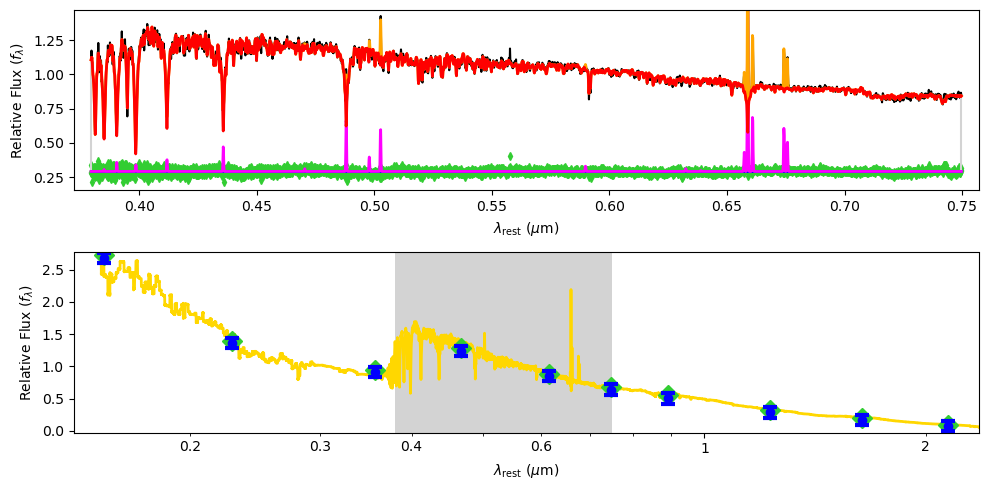

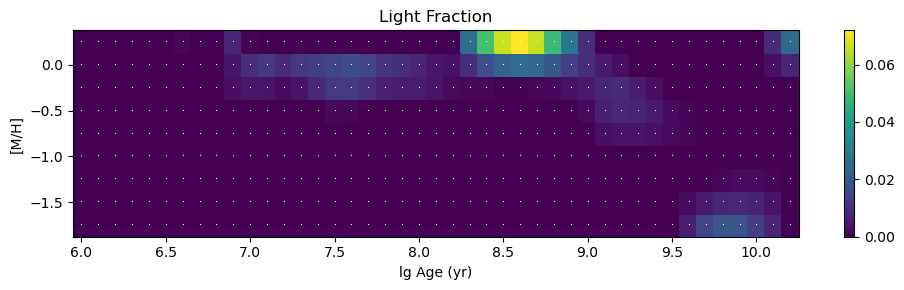

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(211)
pp.plot(phot=False, gas_clip=True)
plt.subplot(212)
pp.plot(spec=False, gas_clip=True)
plt.tight_layout()

plt.figure(figsize=(10,3))
sps.plot(light_weights)
plt.title("Light Fraction")
plt.tight_layout()
plt.pause(5);